# Random Forest


In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from datetime import datetime


### Train table
I need to have a table to train the data, this is the export from BQ

In [310]:
df = pd.read_csv('./train_tables/train_table_23042025.csv')
df.head()

,conversion_flag,user_pseudo_id,device_category,operating_system,platform,city,browser,traffic_source,device_brand,cnt_page_views,...,cnt_form_step_personal_details,cnt_form_step_additional_information,cnt_form_step_assessment_summary,cnt_form_step_policy_owner_details,cnt_form_step_commencement_commissions,cnt_form_step_policy_declaration,cnt_form_step_medical_consent,cnt_form_step_submission_instructions,cnt_form_step_submit_application,cnt_form_step_standalone_ci
0,0,1.095798e+09,desktop,Windows,WEB,Sydney,Edge,organic,Microsoft,2,...,0,0,0,0,0,0,0,0,0,0
1,0,1.684621e+09,desktop,Windows,WEB,Perth,Edge,(none),Microsoft,2,...,0,0,0,0,0,0,0,0,0,0
2,0,1.108570e+09,mobile,Android,WEB,Melbourne,Samsung Internet,(none),NaN,2,...,0,0,0,0,0,0,0,0,0,0
3,0,1.776556e+09,mobile,iOS,WEB,Bungendore,Safari,(none),Apple,4,...,0,0,0,0,0,0,0,0,0,0
4,0,2.855267e+08,desktop,Macintosh,WEB,Kyoto,Chrome,organic,Apple,4,...,0,0,0,0,0,0,0,0,0,0


## Feature engineering
I need to fix the encoding on non numerical categories, and convert them to a binary, I used one-hot encoding to convert to true or false, and expand columns based on dimension value


In [311]:

X = df.drop(['conversion_flag','user_pseudo_id'], axis=1)
Y = df['conversion_flag']

categorical_features = ['device_category', 'operating_system', 'platform', 'city', 'browser', 'traffic_source', 'device_brand']
X_encoded = pd.get_dummies(X, columns=categorical_features)







## Model 

I used Random forest classifier as we are trying to predict a binary classification of yes or no

In [312]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)

## Test and learn

This frame work allows splitting the data and saving a bit of data for testing purposes

In [313]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

In [314]:
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

## Evaluation

here we need to test for precision, recall, and accuracy. Overally mae and mse are non relevant for a classification model.

In [317]:
y_pred = rf.predict(X_test)

    
# Calculate metrics
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
    
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")



Precision: 0.9078694817658349
Recall: 0.8907721280602636
F1 Score: 0.8992395437262357
Accuracy: 0.9781082197439075


## Load up prediciton Table


In [319]:


pred_df = pd.read_csv('./predict_tables/predict_table_24042025.csv', dtype={'user_pseudo_id': str})
X_pred = pred_df.drop(['conversion_flag', 'user_pseudo_id'], axis=1)
categorical_features = ['device_category', 'operating_system', 'platform', 'city', 'browser', 'traffic_source', 'device_brand']
X_pred_encoded = pd.get_dummies(X_pred, columns=categorical_features)

train_columns = X_encoded.columns.tolist()  #this caused issues because some values didnt exist in my pred table so it meant we have to find the missing ones and set to 0
X_pred_encoded = X_pred_encoded.reindex(columns=train_columns, fill_value=0)

In [320]:
y_pred = rf.predict(X_pred_encoded)
probability_pred = rf.predict_proba(X_pred_encoded)[:, 1]

## Getting an Audience list


In [321]:
#adding back the user_pseudo_id so we can see the results

results = pd.DataFrame({
    'user_pseudo_id': pred_df['user_pseudo_id'],
    'predicted_value': probability_pred,
    'predicted_conversion': (y_pred > 0.5).astype(int)
})


In [322]:

bins = [0, 0.3, 0.85, 1.0] 
labels = ['LOW', 'MEDIUM', 'HIGH']

results['conversion_probability_group'] = pd.cut(results['predicted_value'], 
                                           bins=bins, 
                                           labels=labels, 
                                           include_lowest=True)


prob_group_counts = results['conversion_probability_group'].value_counts().sort_index()
results.to_csv(f'./output/scikit_rfc_prediction_results_grouped_{datetime.now().strftime("%d%m%Y")}.csv', index=False)
print(prob_group_counts)

conversion_probability_group
LOW       32356
MEDIUM      259
HIGH         54
Name: count, dtype: int64


## Plotting results

probability_group
0-10%      10780
10-20%       143
20-30%        42
30-40%        34
40-50%        20
50-60%         7
60-70%        16
70-80%        19
80-90%        13
90-100%       20
Name: count, dtype: int64


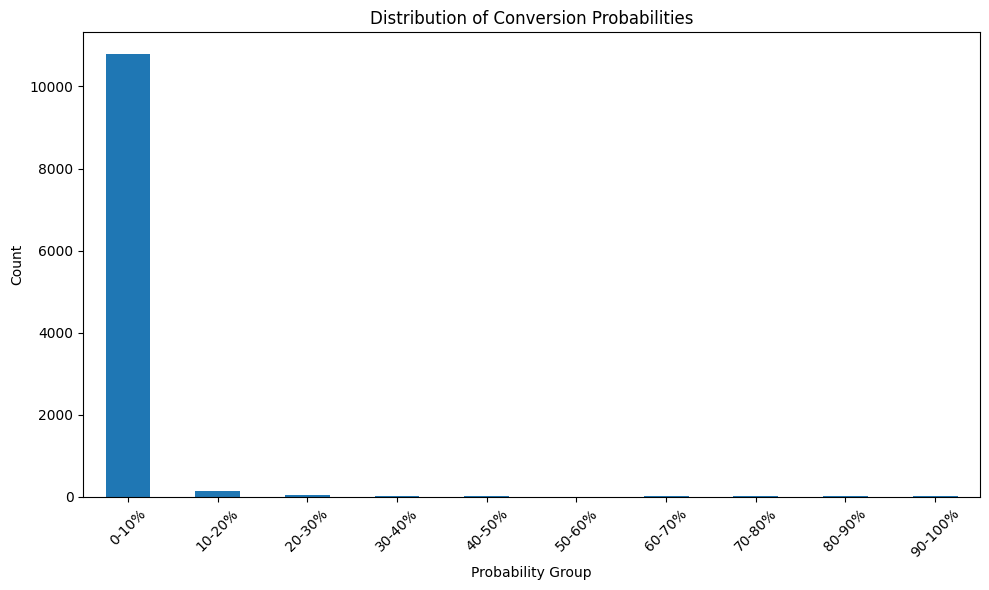

In [290]:
#classify conversion_probabilty in groups [0% to 10%], [10% to 20%], [20% to 30%], [30% to 40%], [40% to 50%], [50% to 60%], [60% to 70%], [70% to 80%], [80% to 90%], [90% to 100%
# Create bins for conversion probability from 0% to 100% in 10% increments
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Classify conversion probabilities into bins
results['probability_group'] = pd.cut(results['predicted_value'], bins=bins, labels=labels, include_lowest=True)

# Display the count of records in each bin
prob_group_counts = results['probability_group'].value_counts().sort_index()
print(prob_group_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
prob_group_counts.plot(kind='bar')
plt.title('Distribution of Conversion Probabilities')
plt.xlabel('Probability Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [299]:
#results where predicted value is greater than 0.4
positive_results = results[results['predicted_value'] > 0]

positive_results.to_csv(f'./output/scikit_rfc_positive_results_{datetime.now().strftime("%d%m%Y")}.csv', index=False)





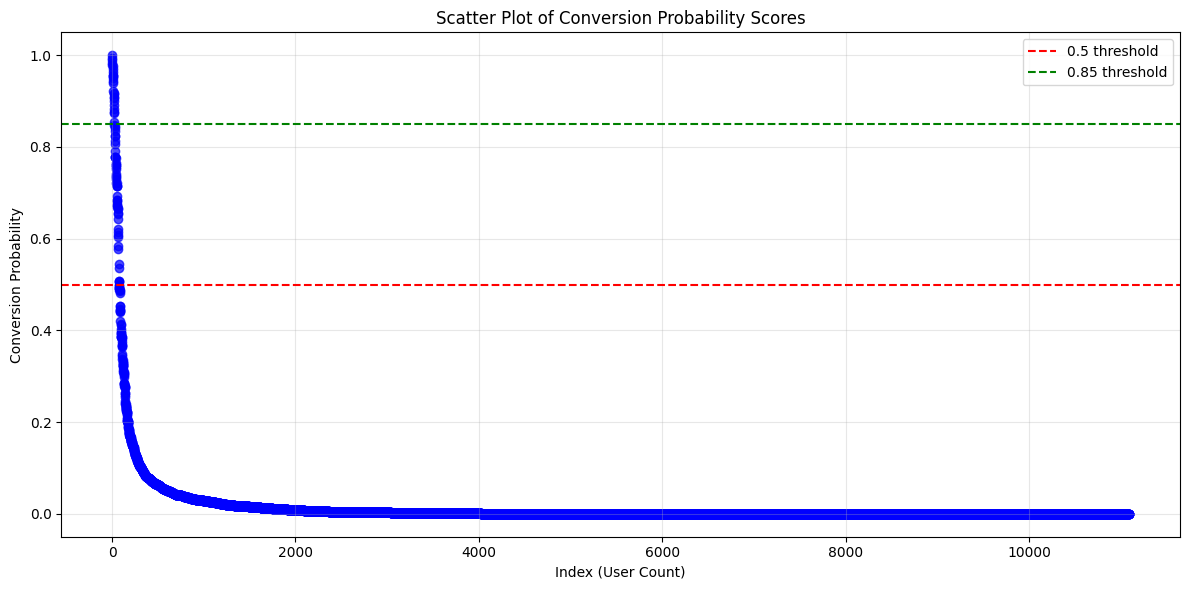

In [292]:
# Create a scatter plot of just the conversion probability scores
plt.figure(figsize=(12, 6))

results = results.sort_values(by=['predicted_value'], ascending=False)
# Use index as x-axis to spread out the points
plt.scatter(range(len(results)), results['predicted_value'], alpha=0.7, color='blue')

# Add a horizontal line at common threshold values
plt.axhline(y=0.5, color='red', linestyle='--', label='0.5 threshold')
plt.axhline(y=0.85, color='green', linestyle='--', label='0.85 threshold')

# Add labels and title
plt.xlabel('Index (User Count)')
plt.ylabel('Conversion Probability')
plt.title('Scatter Plot of Conversion Probability Scores')

# Add legend and grid
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

['cnt_page_views', 'cnt_sessions', 'cnt_site_search', 'cnt_download', 'cnt_form_step', 'cnt_form_step_life_plan', 'cnt_form_step_income_protection', 'cnt_form_step_duty_of_disclosure', 'cnt_form_step_personal_details', 'cnt_form_step_additional_information', 'cnt_form_step_assessment_summary', 'cnt_form_step_policy_owner_details', 'cnt_form_step_commencement_commissions', 'cnt_form_step_policy_declaration', 'cnt_form_step_medical_consent', 'cnt_form_step_submission_instructions', 'cnt_form_step_submit_application', 'cnt_form_step_standalone_ci', 'device_category_desktop', 'device_category_mobile', 'device_category_tablet', 'operating_system_Android', 'operating_system_Chrome OS', 'operating_system_Linux', 'operating_system_Macintosh', 'operating_system_Windows', 'operating_system_iOS', 'platform_WEB', 'city_29351', 'city_66809', 'city_66978', 'city_72351', 'city_78355', 'city_Accra', 'city_Addis Ababa', 'city_Adelaide', 'city_Agrinio', 'city_Ahangama', 'city_Ahmedabad', 'city_Al Jubail

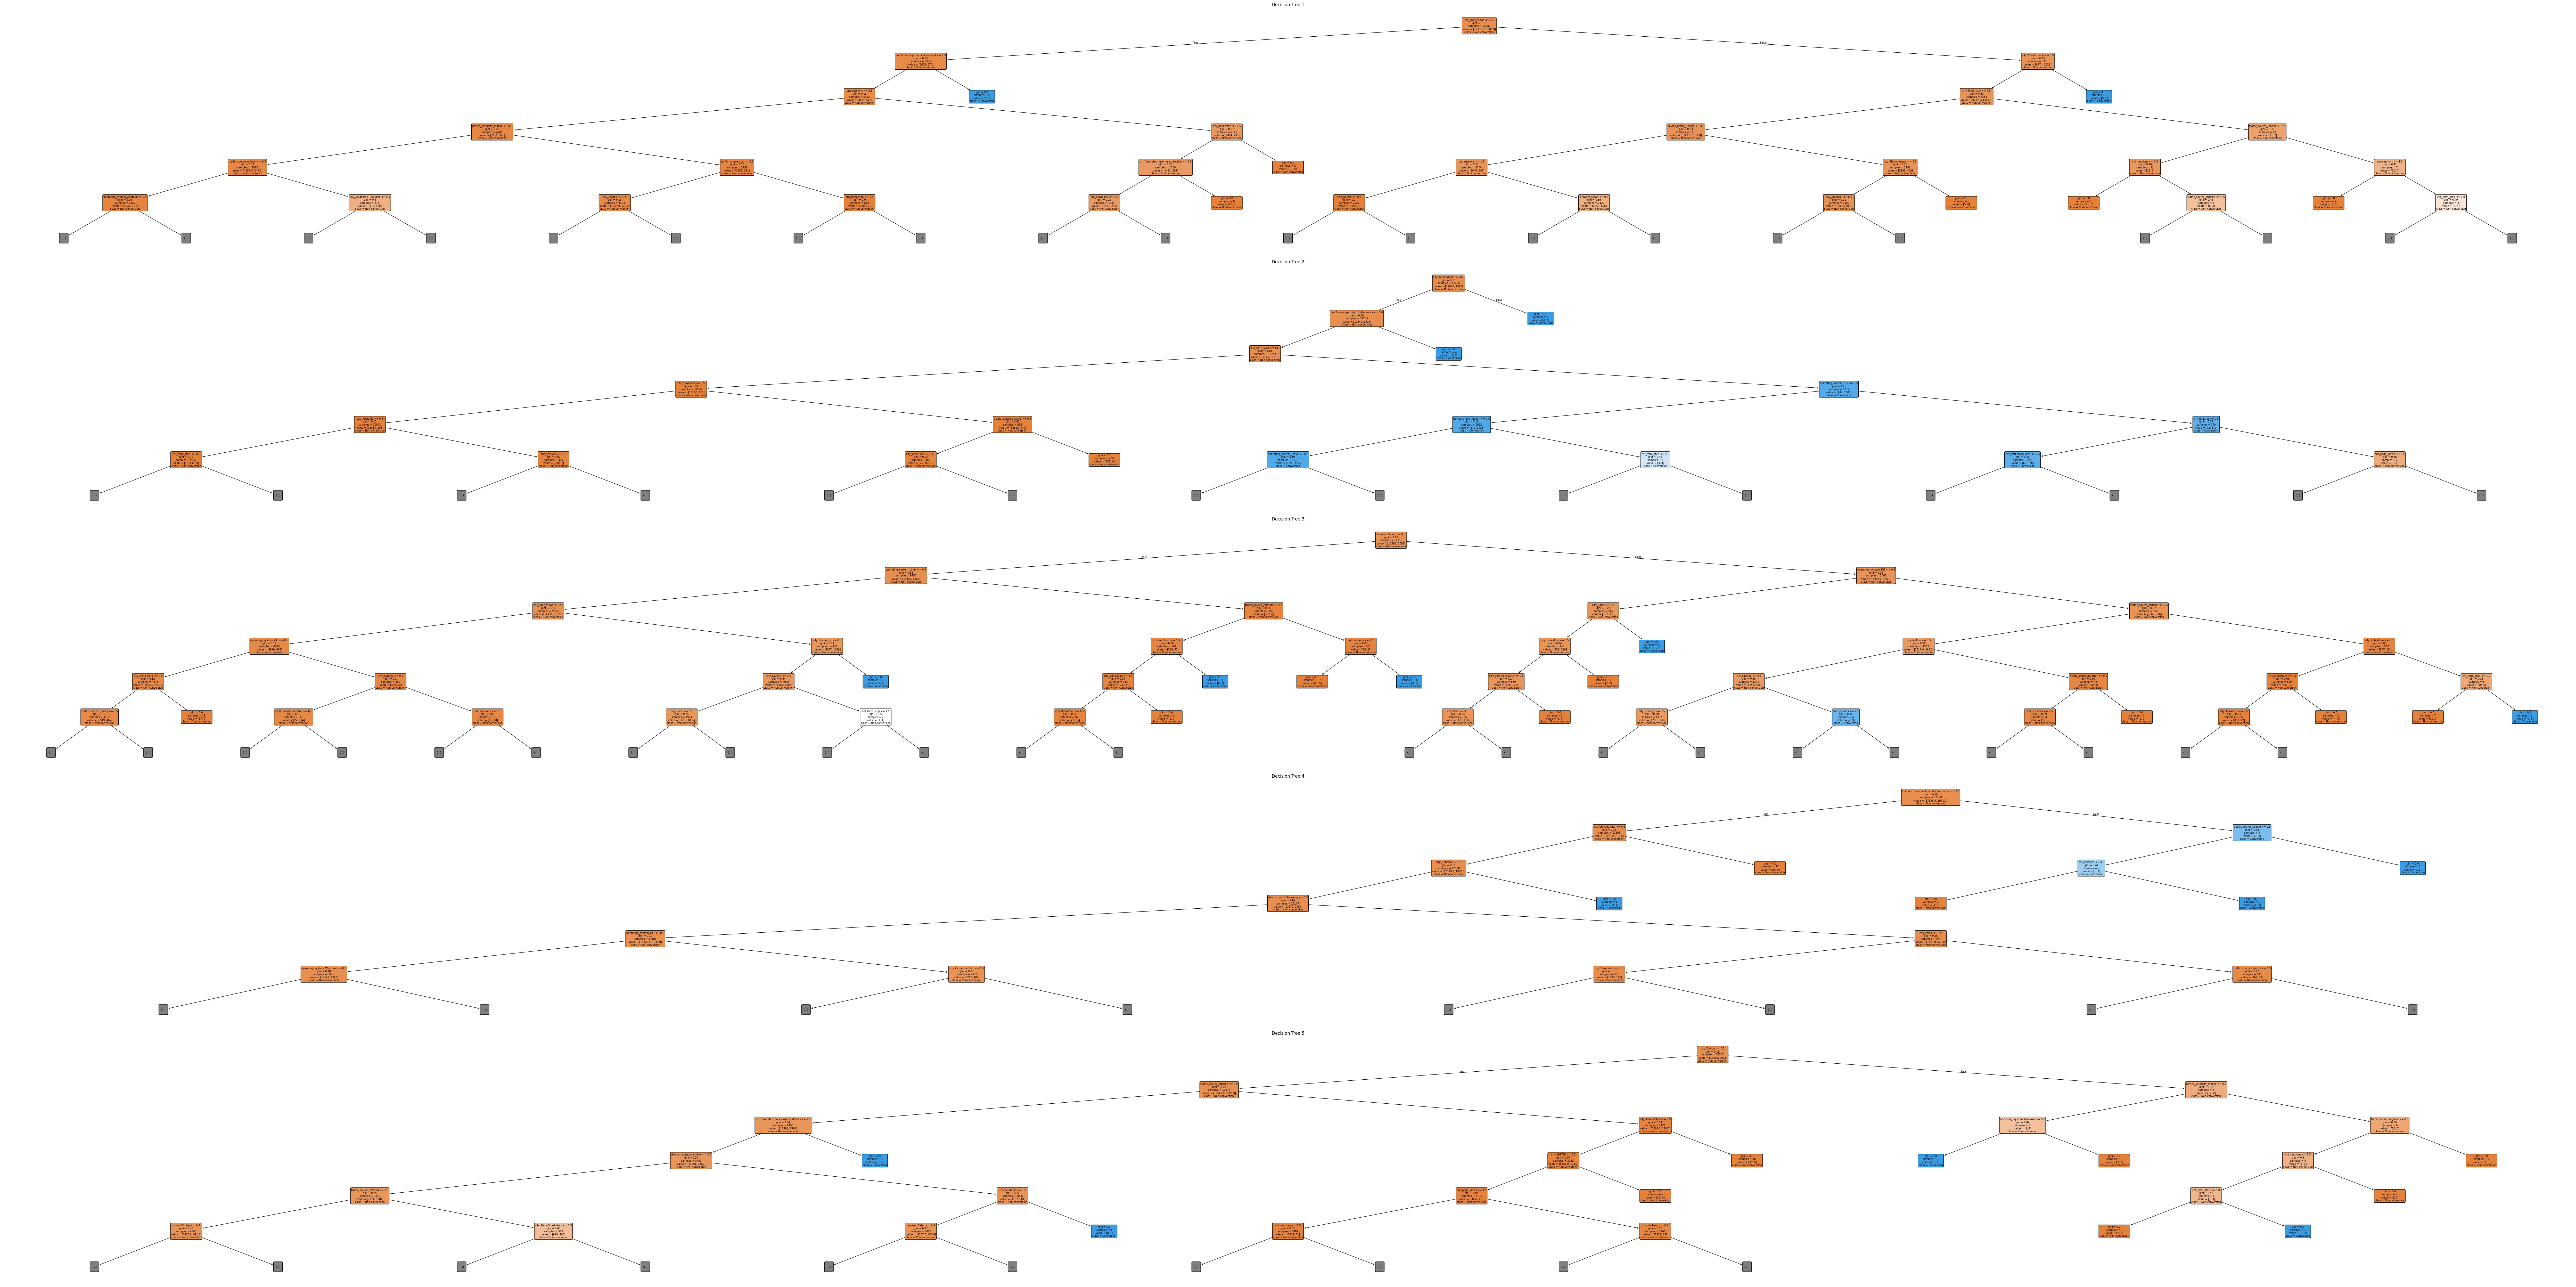

In [307]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd


feature_names = X_pred_encoded.columns.tolist()
print(feature_names)

# Define class names (adjust if your target isn't 0 and 1)
# Only used if 'rf' is a classifier
class_names = ['Non-conversion', 'Conversion']

# Visualize the first 3 trees from the forest
num_trees_to_plot = 5
plt.figure(figsize=(100, 10 * num_trees_to_plot)) # Adjust size as needed

for i in range(min(num_trees_to_plot, len(rf.estimators_))):
    tree_to_plot = rf.estimators_[i]
    plt.subplot(num_trees_to_plot, 1, i + 1)

    plot_tree(tree_to_plot,
                feature_names=feature_names,
                # Use class_names only if it's a classifier model
                class_names=class_names if hasattr(rf, 'classes_') else None,
                filled=True,
                rounded=True,
                fontsize=7, # Adjust font size for readability
                max_depth=5, # Limit depth to keep the plot manageable
                precision=2) # Show values with 2 decimal places
    plt.title(f"Decision Tree {i+1}")

plt.tight_layout()
plt.savefig('decision_trees.png')
plt.show()



Here's the content converted to markdown:

---

### Nature of the Problem:
- **Random Forest Classifier**: Designed for classification tasks, making it ideal for predicting binary outcomes (0 or 1).
- **Linear Regression**: Designed for continuous outcomes, not binary classification.

### Handling Non-linearity:
- **Random Forest**: Captures complex, non-linear relationships between features and the target variable by combining multiple decision trees.
- **Linear Regression**: Assumes a linear relationship, which may not capture the true nature of the data.

### Robustness to Overfitting:
- **Random Forest**: Uses ensemble learning to reduce overfitting by averaging multiple trees.
- **Linear Regression**: More prone to overfitting, especially with many features or noise.

### Feature Importance:
- **Random Forest**: Provides insights into feature importance, helping identify which features contribute most to predictions.
- **Linear Regression**: Coefficients indicate feature impact, but less robust to multicollinearity.

### Performance Metrics:
- **Random Forest**: Directly optimizes for classification metrics like accuracy, precision, recall, and F1-score.
- **Linear Regression**: Optimizes for minimizing error in continuous predictions, not suitable for classification metrics.

---

